In [1]:
import numpy as np

import torch
import quairkit as qkit
from quairkit import to_state, Hamiltonian
from quairkit.database import *
from quairkit.qinfo import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from qsp import *
from qite import *

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

font_family = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = font_family
plt.rcParams["font.size"] = 18

In [4]:
qkit.set_dtype('complex128')
revise_tol(1e-40)

## Experiment setting

prepare Hamiltonian

In [5]:
num_qubits = 4

H = normalized_heisenberg_hamiltonian(n=num_qubits, factor=1.5, hx=-0.5, hz=0, hxx=-1, hyy=-1, hzz=-1)

In [6]:
eigvals, eigvecs = torch.linalg.eigh(H.matrix)

ground_state_energy = eigvals[0].item()
ground_state = to_state(eigvecs[:, 0])

print(f'ground state energy = {ground_state_energy}')

ground state energy = -0.5156684612641718


Prepare input state that has state overlap $1/\sqrt{2}$ with the ground state.

In [7]:
coef_0, coef_rest = 1 / np.sqrt(2), 1 / np.sqrt(2 * (2 ** num_qubits - 1))
phi_state = to_state(coef_0 * eigvecs[:, 0] + coef_rest * eigvecs[:, 1:].sum(dim=1))

gamma = torch.abs(phi_state.bra @ ground_state.ket).item()
print(f'The state overlap between input state and ground state is {gamma}')

The state overlap between input state and ground state is 0.7071067811865464


Prepare ideal ITE state $\ket{\phi(\tau)}$ for $\tau = 20$

In [8]:
tau = 20
deg = 288

ite_op = torch.matrix_exp(-tau * H.matrix)
ideal_state = ite_op @ phi_state.ket
ideal_state = to_state(ideal_state / torch.linalg.norm(ideal_state))

Prepare evolution operator

In [9]:
U = torch.matrix_exp(-1j * H.matrix)

## Compute data

In [10]:
list_guess_lambda = np.linspace(-ground_state_energy - 0.2, -ground_state_energy + 1/tau + 0.1, 100)

list_fidelity, list_probability = [], []

In [11]:
proj = nkron(zero_state(1).bra, eye(2 ** (num_qubits)))
input_state = nkron(zero_state(1), phi_state)

for guess_lambda in list_guess_lambda:
    list_theta, list_phi = qite.get_qpp_angle(guess_lambda=guess_lambda, tau=tau, deg=deg, learn=False)

    cir = qpp_cir(list_theta, list_phi, U)
    output_state = proj @ cir(input_state).ket
    state_norm = torch.linalg.norm(output_state).item()
    
    list_probability.append(state_norm**2)
    output_state = output_state / state_norm

    list_fidelity.append(state_fidelity(ideal_state, output_state))

## Plot

In [12]:
probability_lower_bound = 0.85**2 * np.exp(-2) * np.abs(gamma)**2

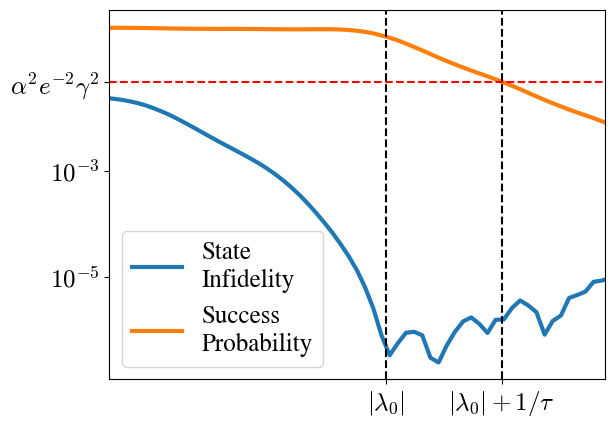

In [13]:
plt.plot(list_guess_lambda, np.log10(1 - np.array(list_fidelity)), label='State\nInfidelity', color='C0', lw=3)
plt.plot(list_guess_lambda, np.log10(list_probability), label='Success\nProbability', color='C1', lw=3)


plt.axvline(x=-ground_state_energy, color='black', linestyle='--')
plt.axvline(x=-ground_state_energy + 1 / tau, color='black', linestyle='--')

plt.axhline(y=np.log10(probability_lower_bound), color='red', linestyle='--')


plt.xticks([-ground_state_energy, -ground_state_energy + 1 / tau], ['$|\lambda_0|$', '$|\lambda_0| + 1 / \\tau$'])
plt.yticks([np.log10(probability_lower_bound.item()), -3, -5], ['$\\alpha^2e^{-2}\gamma^2$', '$10^{-3}$', '$10^{-5}$'])

plt.xlim([-ground_state_energy - 0.12, -ground_state_energy + 1/tau + 0.045])
plt.legend(loc='lower left')

plt.show()

---

In [14]:
qkit.print_info()


---------VERSION---------
quairkit: 0.4.0
torch: 2.7.0+cpu
numpy: 1.26.0
scipy: 1.14.1
matplotlib: 3.10.0
---------SYSTEM---------
Python version: 3.10.16
OS: Windows
OS version: 10.0.26100
---------DEVICE---------
CPU: ARMv8 (64-bit) Family 8 Model 1 Revision 201, Qualcomm Technologies Inc
